### Import Libraries

In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Clustering
from sklearn.cluster import KMeans

# Evaluation
from sklearn.metrics import silhouette_score

# Dimensionality reduction
from sklearn.decomposition import PCA

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


#### Load and Merge Data

In [4]:
# Load datasets
riders = pd.read_csv("Ridewise -Project 1/riders.csv")
trips = pd.read_csv("Ridewise -Project 1/trips.csv")

# Convert date columns
riders['signup_date'] = pd.to_datetime(riders['signup_date'], errors='coerce')
trips['pickup_time'] = pd.to_datetime(trips['pickup_time'], utc=True, errors='coerce')
trips['dropoff_time'] = pd.to_datetime(trips['dropoff_time'], utc=True, errors='coerce')

# Merge datasets
data = pd.merge(trips, riders, on='user_id', how='left')

#### Feature Engineering (User-Level Features)

In [5]:
# Aggregate trip behavior per customer.

# Trip duration (minutes)
data['trip_duration'] = (data['dropoff_time'] - data['pickup_time']).dt.total_seconds() / 60

In [7]:
# Aggregate at user level
user_features = data.groupby('user_id').agg({'trip_id': 'count','fare': 'sum','trip_duration': 'mean','surge_multiplier': 'mean',
    'tip': 'sum'}).reset_index()

In [8]:
# Rename columns
user_features.columns = ['user_id','total_trips','total_spent','avg_trip_duration','avg_surge','total_tip']

#### Select Features for Segmentation

In [10]:
# Behavioral features only (no churn).

seg_features = ['total_trips','total_spent','avg_trip_duration','avg_surge', 'total_tip']
seg_data = user_features[seg_features]

#### Scale the Data

In [12]:
# K-Means is distance-based → scaling is required.
scaler = StandardScaler()

seg_scaled = scaler.fit_transform(seg_data)

#### Determine Optimal K (Elbow Method)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

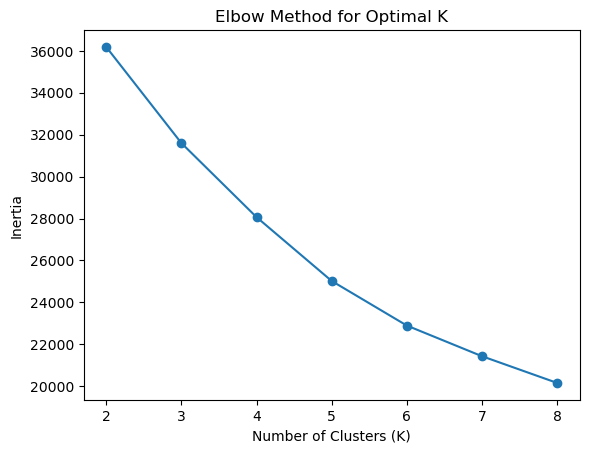

In [15]:
inertia = []
K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(seg_scaled)
    inertia.append(kmeans.inertia_)
    plt.figure()


plt.plot(list(K_range), inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.show()

#### Validate K Using Silhouette Score

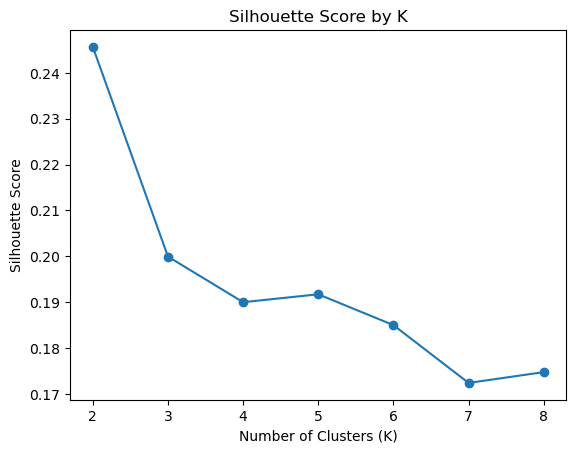

In [18]:
sil_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(seg_scaled)
    sil_scores.append(silhouette_score(seg_scaled, labels))

plt.figure()
plt.plot(list(K_range), sil_scores, marker='o')
plt.title("Silhouette Score by K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

#### Selection of Optimal Number of Clusters

##### The Silhouette Score was used to evaluate cluster separation for different values of K.

##### The highest silhouette score was observed at K = 2, indicating the strongest statistical separation. However, this configuration results in overly broad customer groupings with limited business interpretability.

##### A value of K = 3 was selected as a balanced solution, providing meaningful segmentation aligned with business use cases such as regular, occasional, and leisure users, while maintaining acceptable cluster separation.

#### Train Final K-Means Model (Choose K = 3)

In [19]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

user_features['segment'] = kmeans.fit_predict(seg_scaled)


In [20]:
user_features['segment'].value_counts()

segment
1    3799
0    3679
2    2522
Name: count, dtype: int64

#### Segment Profiling (Interpretation Table)

In [21]:
segment_profile = user_features.groupby('segment')[seg_features].mean().round(2)

segment_profile

,total_trips,total_spent,avg_trip_duration,avg_surge,total_tip
segment,,,,,
0,24.39,379.32,31.96,1.14,13.19
1,17.15,251.67,31.99,1.10,7.19
2,17.89,288.93,31.88,1.21,7.17


#### Segment Size Visualization

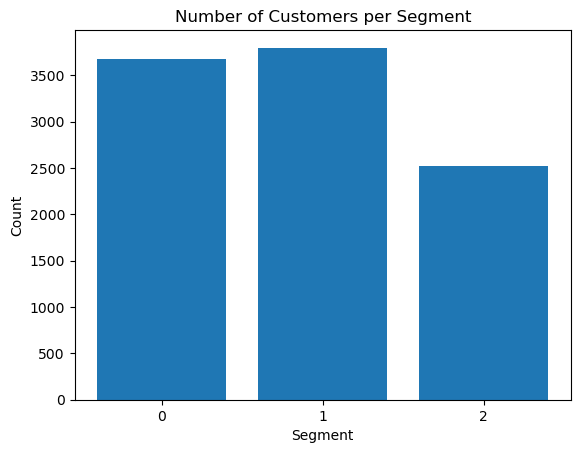

In [22]:
segment_sizes = user_features['segment'].value_counts().sort_index()

plt.figure()
plt.bar(segment_sizes.index.astype(str), segment_sizes.values)
plt.title("Number of Customers per Segment")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.show()

#### Visualize Segments Using PCA (2D Plot)

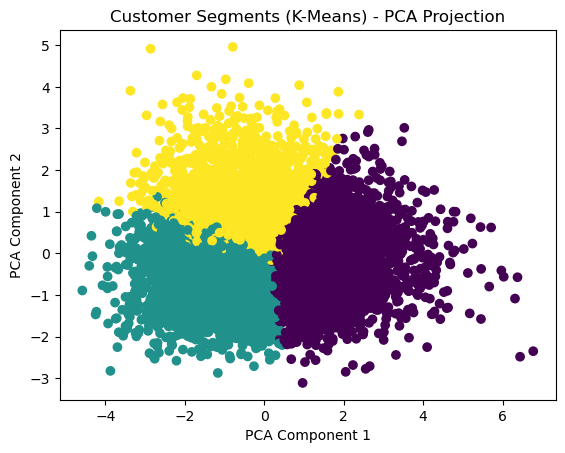

In [24]:
# This makes your clustering easy to understand.
pca = PCA(n_components=2, random_state=42)

seg_pca = pca.fit_transform(seg_scaled)

plt.figure()
plt.scatter(
    seg_pca[:,0],
    seg_pca[:,1],
    c=user_features['segment']
)

plt.title("Customer Segments (K-Means) - PCA Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()



#### Assign Business Segment Names

In [29]:
segment_map = {
    0: "Regular Commuters (High-Value Users)",
    1: "Occasional Users (Low Engagement)",
    2: "Peak-Time / Leisure Users"}

user_features['segment_name'] = user_features['segment'].map(segment_map)

In [30]:
user_features[['user_id', 'segment', 'segment_name']].head()

,user_id,segment,segment_name
0,R00000,0,Regular Commuters (High-Value Users)
1,R00001,1,Occasional Users (Low Engagement)
2,R00002,0,Regular Commuters (High-Value Users)
3,R00003,1,Occasional Users (Low Engagement)
4,R00004,2,Peak-Time / Leisure Users


#### Customer Segment Interpretation

##### Based on behavioral characteristics, three distinct customer segments were identified:

##### Segment 0 – Regular Commuters (High-Value Users):
##### This group exhibits the highest trip frequency, spending, and tipping behavior. These customers represent the most engaged and valuable users and are ideal candidates for loyalty and premium programs.

##### Segment 1 – Occasional Users (Low Engagement):
##### This segment shows the lowest levels of activity and spending. These users are likely to be price-sensitive and exhibit higher churn risk, making them suitable targets for reactivation and promotional campaigns.

##### Segment 2 – Peak-Time / Leisure Users:
##### Users in this group demonstrate moderate engagement but experience the highest surge pricing. This suggests usage during peak periods or leisure activities. Targeted event-based and off-peak incentives may improve retention for this segment.

##### These segments enable RideWise to implement differentiated retention and marketing strategies based on customer behavior.